<a href="https://colab.research.google.com/github/tsubauaaa/Tensorflow2.0-tutorials/blob/master/Tensorflow2_overfit_and_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 過学習と学習不足
いつものように、この例のプログラムはtf.keras APIを使用する。

これまでの例、つまり、映画レビューの分類と燃費の推定では、検証用データでのモデルの正解率が、数エポックでピークを迎え、その後低下するという現象が見られた。

言い換えると、モデルが訓練用データを過学習したと考えられる。過学習への対処の仕方を学ぶことは重要。訓練用データセットで高い正解率を達成することは難しくないが、我々は、（これまで見たこともない）テスト用データに汎化したモデルを開発したい。

過学習の反対語は学習不足(underfitting)。学習不足は、モデルがテストデータに対してまだ改善の余地がある場合に発生する。学習不足の原因は様々。モデルが十分強力でないとか、正則化のしすぎだとか、単に訓練時間が短すぎるといった理由がある。学習不足は、訓練用データの中の関連したパターンを学習しきっていないということを意味する。

モデルの訓練をやりすぎると、モデルは過学習を始め、訓練用データの中のパターンで、テストデータには一般的ではないパターンを学習する。我々は、過学習と学習不足の中間を目指す必要がある。これから見ていくように、ちょうどよいエポック数だけ訓練を行うというのは必要なスキル。

過学習を防止するための、最良の解決策は、より多くの訓練用データを使うこと。多くのデータで訓練を行えば行うほど、モデルは自然により汎化していく様になる。これが不可能な場合、次善の策は正則化のようなテクニックを使うこと。正則化は、モデルに保存される情報の量とタイプに制約を課すもの。ネットワークが少数のパターンしか記憶できなければ、最適化プロセスにより、最も主要なパターンのみを学習することになり、より汎化される可能性が高くなる。

このノートブックでは、重みの正則化とドロップアウトという、よく使われる2つの正則化テクニックを紹介する。これらを使って、IMDBの映画レビューを分類するノートブックの改善を図る。

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


### IMDBデータセットのダウンロード
以前のノートブックで使用したエンベディングの代わりに、ここでは文をマルチホットエンコードする。このモデルは、訓練用データセットをすぐに過学習する。このモデルを使って、過学習がいつ起きるかということと、どうやって過学習と戦うかをデモする。

リストをマルチホットエンコードすると言うのは、0と1のベクトルにするということ。具体的にいうと、例えば[3, 5]というシーケンスを、インデックス3と5の値が1で、それ以外がすべて0の、10,000次元のベクトルに変換するということを意味する。

In [0]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)
def multi_hot_sequences(sequences, dimension):
  # 形状が(len(sequences), dimension)で全て0の行列を作る
  results = np.zeros((len(sequences), dimension))
  for i, word_indices in enumerate(sequences):
    results[i, word_indices] = 1.0 # 特定のインデックスに対してresult[i]を1に設定する
  return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

結果として得られるマルチホットベクトルの1つを見てみる。単語のインデックスは頻度順にソートされている。このため、インデックスが0に近いほど１が多く出現するはず。分布を見てみる。

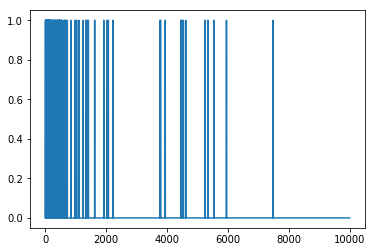

In [15]:
plt.plot(train_data[0])

### 過学習のデモ
過学習を防止するための最も単純な方法は、モデルのサイズ、すなわち、モデル内の学習可能なパラメータの数を小さくすること（学習パラメータの数は、層の数と層ごとのユニット数で決まる）。ディープラーニングでは、モデルの学習可能なパラメータ数を、しばしばモデルの「キャパシティ」と呼ぶ。直感的に考えれば、パラメータ数の多いモデルほど「記憶容量」が大きくなり、訓練用のサンプルとその目的変数の間の辞書のようなマッピングをたやすく学習することができる。このマッピングには汎化能力がまったくなく、これまで見たことが無いデータを使って予測をする際には役に立たない。

ディープラーニングのモデルは訓練用データに適応しやすいが、本当のチャレレンジは汎化であって適応ではないということを、肝に銘じておく必要がある。

一方、ネットワークの記憶容量が限られている場合、前述のようなマッピングを簡単に学習することはできない。損失を減らすためには、より予測能力が高い圧縮された表現を学習しなければならない。同時に、モデルを小さくしすぎると、訓練用データに適応するのが難しくなる。「多すぎる容量」と「容量不足」の間にちょうどよい容量がある。

残念ながら、（層の数や、層ごとの大きさといった）モデルの適切なサイズやアーキテクチャを決める魔法の方程式はない。一連の異なるアーキテクチャを使って実験を行う必要がある。

適切なモデルのサイズを見つけるには、比較的少ない層の数とパラメータから始めるのがベスト。それから、検証用データでの損失値の改善が見られなくなるまで、徐々に層の大きさを増やしたり、新たな層を加えたりする。映画レビューの分類ネットワークでこれを試してみよう。

比較基準として、Dense層だけを使ったシンプルなモデルを構築し、その後、それより小さいバージョンと大きいバージョンを作って比較する。

### 比較基準を作る

In [16]:
baseline_model = keras.Sequential([
    # `.summary`をみるために`input_shape`が必要
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])
baseline_model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7b524000b8>>

In [17]:
baseline_history = baseline_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.4933 - accuracy: 0.7964 - binary_crossentropy: 0.4933 - val_loss: 0.3328 - val_accuracy: 0.8781 - val_binary_crossentropy: 0.3328
Epoch 2/20
25000/25000 - 3s - loss: 0.2457 - accuracy: 0.9128 - binary_crossentropy: 0.2457 - val_loss: 0.2825 - val_accuracy: 0.8876 - val_binary_crossentropy: 0.2825
Epoch 3/20
25000/25000 - 3s - loss: 0.1775 - accuracy: 0.9376 - binary_crossentropy: 0.1775 - val_loss: 0.2974 - val_accuracy: 0.8822 - val_binary_crossentropy: 0.2974
Epoch 4/20
25000/25000 - 3s - loss: 0.1410 - accuracy: 0.9535 - binary_crossentropy: 0.1410 - val_loss: 0.3173 - val_accuracy: 0.8781 - val_binary_crossentropy: 0.3173
Epoch 5/20
25000/25000 - 3s - loss: 0.1153 - accuracy: 0.9636 - binary_crossentropy: 0.1153 - val_loss: 0.3496 - val_accuracy: 0.8728 - val_binary_crossentropy: 0.3496
Epoch 6/20
25000/25000 - 3s - loss: 0.0959 - accuracy: 0.9701 - binary_crossentropy: 0.0959 - val_loss: 0.3852

### より小さいモデルの構築
今作成したばかりの比較基準となるモデルに比べて隠れユニット数が少ないモデルを作る。

In [18]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')                
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4)                 40004     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


同じデータを使って訓練する。

In [19]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2
                                    )

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.6408 - accuracy: 0.7124 - binary_crossentropy: 0.6408 - val_loss: 0.5801 - val_accuracy: 0.7993 - val_binary_crossentropy: 0.5801
Epoch 2/20
25000/25000 - 3s - loss: 0.5024 - accuracy: 0.8562 - binary_crossentropy: 0.5024 - val_loss: 0.4573 - val_accuracy: 0.8550 - val_binary_crossentropy: 0.4573
Epoch 3/20
25000/25000 - 3s - loss: 0.3806 - accuracy: 0.8907 - binary_crossentropy: 0.3806 - val_loss: 0.3715 - val_accuracy: 0.8751 - val_binary_crossentropy: 0.3715
Epoch 4/20
25000/25000 - 3s - loss: 0.3011 - accuracy: 0.9088 - binary_crossentropy: 0.3011 - val_loss: 0.3248 - val_accuracy: 0.8830 - val_binary_crossentropy: 0.3248
Epoch 5/20
25000/25000 - 3s - loss: 0.2522 - accuracy: 0.9211 - binary_crossentropy: 0.2522 - val_loss: 0.3007 - val_accuracy: 0.8860 - val_binary_crossentropy: 0.3007
Epoch 6/20
25000/25000 - 3s - loss: 0.2191 - accuracy: 0.9298 - binary_crossentropy: 0.2191 - val_loss: 0.2888

### より大きなモデルの構築
練習として、より大きなモデルを作成し、どれほど急速に過学習が起きるかを見ることもできる。次はこのベンチマークに、この問題が必要とするよりはるかに容量の大きなネットワークを追加します。

In [20]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'binary_crossentropy'])
bigger_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


このモデルもまた同じデータを使って訓練する。

In [21]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 19s - loss: 0.3496 - accuracy: 0.8492 - binary_crossentropy: 0.3496 - val_loss: 0.3000 - val_accuracy: 0.8767 - val_binary_crossentropy: 0.3000
Epoch 2/20
25000/25000 - 18s - loss: 0.1438 - accuracy: 0.9487 - binary_crossentropy: 0.1438 - val_loss: 0.3250 - val_accuracy: 0.8731 - val_binary_crossentropy: 0.3250
Epoch 3/20
25000/25000 - 18s - loss: 0.0511 - accuracy: 0.9851 - binary_crossentropy: 0.0511 - val_loss: 0.4362 - val_accuracy: 0.8685 - val_binary_crossentropy: 0.4362
Epoch 4/20
25000/25000 - 18s - loss: 0.0082 - accuracy: 0.9985 - binary_crossentropy: 0.0082 - val_loss: 0.5683 - val_accuracy: 0.8668 - val_binary_crossentropy: 0.5683
Epoch 5/20
25000/25000 - 18s - loss: 9.9914e-04 - accuracy: 1.0000 - binary_crossentropy: 9.9914e-04 - val_loss: 0.6811 - val_accuracy: 0.8690 - val_binary_crossentropy: 0.6811
Epoch 6/20
25000/25000 - 18s - loss: 2.3987e-04 - accuracy: 1.0000 - binary_crossentropy: 2.3987e

### 訓練時と検証時の損失をグラフにする
実線は訓練用データセットの損失、破線は検証用データセットでの損失（検証用データでの損失が小さい方が良いモデル）。これをみると、小さいネットワークのほうが比較基準のモデルよりも過学習が始まるのが遅いことがわかる（4エポックではなく6エポック後）。また、過学習が始まっても性能の低下がよりゆっくりしている。

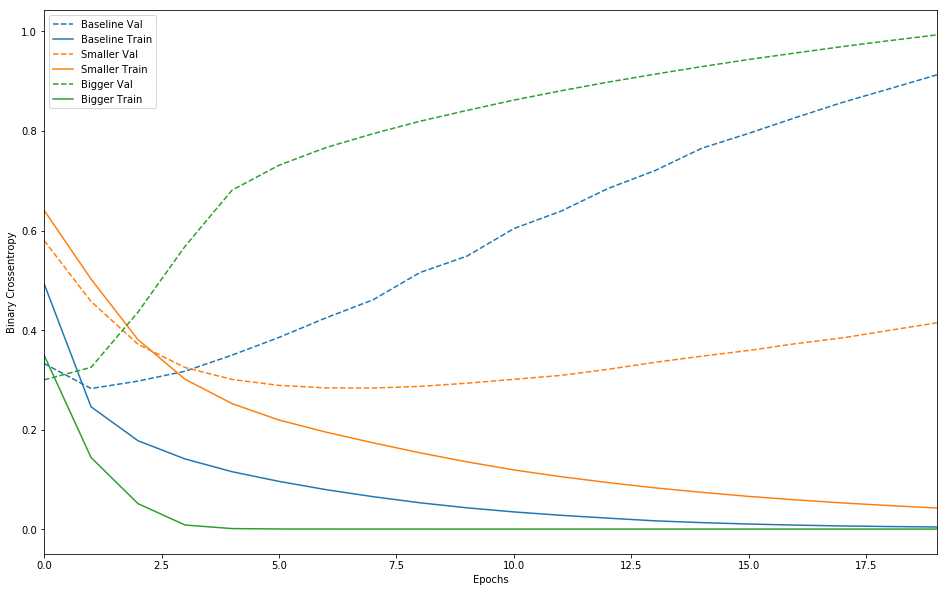

In [22]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16, 10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0, max(history.epoch)])

plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])


より大きなネットワークでは、すぐに、1エポックで過学習が始まり、その度合も強いことに注目。ネットワークの容量が大きいほど訓練用データをモデル化するスピードが早くなる（結果として訓練時の損失値が小さくなり）が、より過学習しやすく（結果として訓練時の損失値と検証時の損失値が大きく乖離しやすく）なる。

### 過学習防止の戦略
#### 重みの正則化を加える
「オッカムの剃刀」の原則。何かの説明が2つあるとすると、最も正しいと考えられる説明は、仮定の数が最も少ない「一番単純な」説明だというもの。この原則は、ニューラルネットワークを使って学習されたモデルにも当てはまる。ある訓練用データとネットワーク構造があって、そのデータを説明できる重みの集合が複数ある時（つまり、複数のモデルがある時）、単純なモデルのほうが複雑なものよりも過学習しにくい。

ここで言う「単純なモデル」とは、パラメータ値の分布のエントロピーが小さいもの（あるいは、上記で見たように、そもそもパラメータの数が少ないもの）。したがって、過学習を緩和するための一般的な手法は、重みが小さい値のみをとることで、重み値の分布がより整然となる（正則）様に制約を与えるもの。これを「重みの正則化」と呼ばれ、ネットワークの損失関数に、重みの大きさに関連するコストを加えることで行われる。このコストには2つの種類がある。

* L1正則化 重み係数の絶対値に比例するコストを加える（重みの「L1ノルム」と呼ばれる）。

* L2正則化 重み係数の二乗に比例するコストを加える（重み係数の二乗「L2ノルム」と呼ばれる）。L2正則化はニューラルネットワーク用語では重み減衰（Weight Decay）と呼ばれる。呼び方が違うので混乱しないように。重み減衰は数学的にはL2正則化と同義である。

L1正則化は重みパラメータの一部を0にすることでモデルを疎にする効果がある。L2正則化は重みパラメータにペナルティを加えるがモデルを疎にすることはない。これは、L2正則化のほうが一般的である理由の一つ。

tf.kerasでは、重みの正則化をするために、重み正則化のインスタンスをキーワード引数として層に加える。ここでは、L2正則化を追加してみる。

In [27]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')                               
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_mode_history = l2_model.fit(train_data, train_labels,
                               epochs=20,
                               batch_size=512,
                               validation_data=(test_data, test_labels),
                               verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.5409 - accuracy: 0.7903 - binary_crossentropy: 0.5018 - val_loss: 0.3947 - val_accuracy: 0.8681 - val_binary_crossentropy: 0.3535
Epoch 2/20
25000/25000 - 3s - loss: 0.3096 - accuracy: 0.9071 - binary_crossentropy: 0.2633 - val_loss: 0.3341 - val_accuracy: 0.8883 - val_binary_crossentropy: 0.2844
Epoch 3/20
25000/25000 - 3s - loss: 0.2526 - accuracy: 0.9310 - binary_crossentropy: 0.2004 - val_loss: 0.3387 - val_accuracy: 0.8868 - val_binary_crossentropy: 0.2847
Epoch 4/20
25000/25000 - 3s - loss: 0.2284 - accuracy: 0.9418 - binary_crossentropy: 0.1727 - val_loss: 0.3519 - val_accuracy: 0.8820 - val_binary_crossentropy: 0.2950
Epoch 5/20
25000/25000 - 3s - loss: 0.2141 - accuracy: 0.9478 - binary_crossentropy: 0.1560 - val_loss: 0.3638 - val_accuracy: 0.8800 - val_binary_crossentropy: 0.3050
Epoch 6/20
25000/25000 - 3s - loss: 0.2039 - accuracy: 0.9526 - binary_crossentropy: 0.1439 - val_loss: 0.3794

l2(0.001)というのは、層の重み行列の係数全てに対して0.001 * 重み係数の値 **2をネットワークの損失値合計に加えることを意味する。このペナルティは訓練時のみに加えられるため、このネットワークの損失値は、訓練時にはテスト時に比べて大きくなることに注意する。

L2正則化の影響を見てみる。

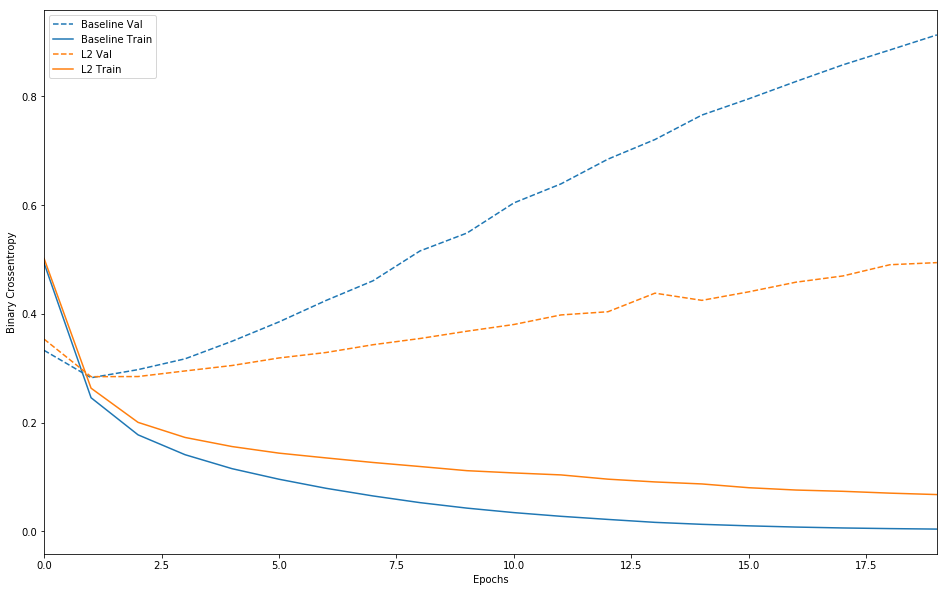

In [28]:
plot_history([('baseline', baseline_history),
              ('l2', l2_mode_history)])

ごのように、L2正則化ありのモデルは比較基準のモデルに比べて過学習しにくくなっている。両方のモデルのパラメータ数は同じであるにもかかわらず。

### ドロップアウトを追加する
ドロップアウトは、ニューラルネットワークの正則化テクニックとして最もよく使われる手法の一つ。この手法は、トロント大学のヒントンと彼の学生が開発したもの。ドロップアウトは層に適用するもので、訓練時に層から出力された特徴量に対してランダムに「ドロップアウト（つまりゼロ化）」を行うもの。例えば、ある層が訓練時にある入力サンプルに対して、普通は[0.2, 0.5, 1.3, 0.8, 1.1] というベクトルを出力するとする。ドロップアウトを適用すると、このベクトルは例えば[0, 0.5, 1.3, 0, 1.1]のようにランダムに散らばったいくつかのゼロを含むようになる。「ドロップアウト率」はゼロ化される特徴の割合で、通常は0.2から0.5の間に設定する。テスト時は、どのユニットもドロップアウトされず、代わりに出力値がドロップアウト率と同じ比率でスケールダウンされる。これは、訓練時に比べてたくさんのユニットがアクティブであることに対してバランスをとるため。

tf.kerasでは、Dropout層を使ってドロップアウトをネットワークに導入できる。ドロップアウト層は、その直前の層の出力に対してドロップアウトを適用する。

それでは、IMDBネットワークに2つのドロップアウト層を追加する。

In [32]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')                                     
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.6157 - accuracy: 0.6687 - binary_crossentropy: 0.6157 - val_loss: 0.4942 - val_accuracy: 0.8584 - val_binary_crossentropy: 0.4942
Epoch 2/20
25000/25000 - 3s - loss: 0.4596 - accuracy: 0.8226 - binary_crossentropy: 0.4596 - val_loss: 0.3690 - val_accuracy: 0.8760 - val_binary_crossentropy: 0.3690
Epoch 3/20
25000/25000 - 3s - loss: 0.3576 - accuracy: 0.8760 - binary_crossentropy: 0.3576 - val_loss: 0.3038 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.3038
Epoch 4/20
25000/25000 - 3s - loss: 0.2987 - accuracy: 0.9030 - binary_crossentropy: 0.2987 - val_loss: 0.2865 - val_accuracy: 0.8880 - val_binary_crossentropy: 0.2865
Epoch 5/20
25000/25000 - 3s - loss: 0.2526 - accuracy: 0.9187 - binary_crossentropy: 0.2526 - val_loss: 0.2862 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.2862
Epoch 6/20
25000/25000 - 3s - loss: 0.2204 - accuracy: 0.9301 - binary_crossentropy: 0.2204 - val_loss: 0.2918

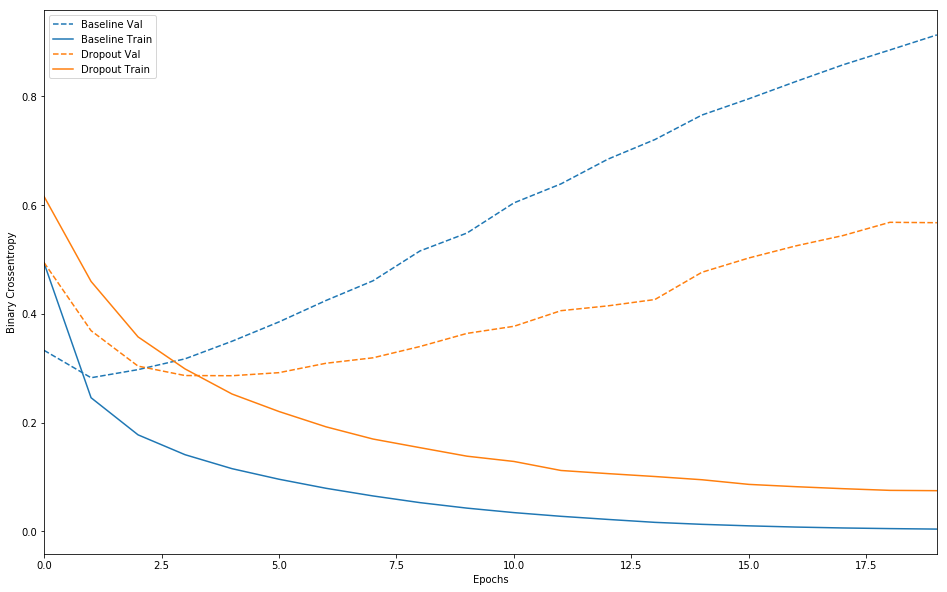

In [33]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

ドロップアウトを追加することで、比較対象モデルより明らかに改善が見られる。

まとめ：ニューラルネットワークにおいて過学習を防ぐ最も一般的な方法は次のとおり。

* 訓練データを増やす
* ネットワークの容量をへらす
* 重みの正則化を行う
* ドロップアウトを追加する
このガイドで触れていない２つの重要なアプローチがある。データ拡張とバッチ正規化。